In [4]:
import chess as ch
import random as rd
import pandas as pd
import numpy as np
import torch
import torch.utils.data
from torch_snippets import Report
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)

c:\Users\heigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(773, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Linear(400, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Linear(600, 773),
            nn.BatchNorm1d(773),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

class GamesDataset(Dataset):
    def __init__(self, games):
        self.x = torch.from_numpy(games).type(torch.FloatTensor)
        self.n_samples = games.shape[0]
    
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_samples

In [ ]:
class SquareClass(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()

        self.seq_forward = nn.Sequential(
            nn.Linear(100, 80),
            nn.BatchNorm1d(80),
            nn.LeakyReLU(),
            nn.Linear(80, 64),
            nn.BatchNorm1d(64),
            nn.Softmax()
        )
        
    def forward(self, x):
        output = self.seq_forward(x)
        return output

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)

print("Loading Data")
games = np.load('Mestrado\Data\positions.npy')
np.random.shuffle(games)

datasetTrain = GamesDataset(games[:int(len(games)*.98)])
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetTest = GamesDataset(games[int(len(games)*.98):])
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Test: {len(dataLoaderTest.dataset)}")

Loading Data
Train: 2195350
Test: 44804


In [45]:
def split_data(dataframe, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    np.random.seed(seed)
    total_rows = len(dataframe)
    rand_indices = np.random.permutation(total_rows)
    
    train_size = int(total_rows * train_ratio)
    val_size = int(total_rows * val_ratio)
    
    train_indices = rand_indices[:train_size]
    val_indices = rand_indices[train_size:train_size + val_size]
    test_indices = rand_indices[train_size + val_size:]
    
    train_data = dataframe.iloc[train_indices]
    val_data = dataframe.iloc[val_indices]
    test_data = dataframe.iloc[test_indices]
    
    return train_data, val_data, test_data

data = pd.read_csv('Dataset\JogoPosFenNext.csv')

train_data, val_data, test_data = split_data(data)

train_data.to_csv('Mestrado/Data/train.csv', index=False)
val_data.to_csv('Mestrado/Data/validation.csv', index=False)
test_data.to_csv('Mestrado/Data/test.csv', index=False)


In [14]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=773, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=400, bias=True)
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=100, bias=True)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=400, bias=True)
    (4): BatchNorm1d(400, eps

In [15]:
start_time = time.time()

num_epochs = 200
model.train()

PATH = 'Mestrado/Models/autoencoder.pth'
file_out = open('Mestrado/Data/outputsAutoencoder.csv','w')
file_out.write(f"Epoch,Loss\n")


print("Start Training")
for epoch in range(num_epochs):

    for pos in dataLoaderTrain:

        pos = pos.to(device)

        recon, code = model(pos)
        loss = criterion(recon, pos)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    for params in optimizer.param_groups:
        params['lr'] *= 0.98
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, PATH)

    print(f"Epoch: {epoch+1}, Loss: {loss.item():4f}")
    file_out.write(f"{epoch+1},{loss.item():4f}\n")
file_out.close()
print("Finish Training")

model.eval()
print("Start Testing")
test_loss_mse = 0
total_diff = 0
total_diff_int = 0
total = 0
right = 0
with torch.no_grad():
    for pos in dataLoaderTest:
        pos = pos.to(device)
        posnp = pos.cpu().detach().numpy()

        recon, code = model(pos)
        
        pred = (recon.cpu().detach().numpy() > .5).astype(int)
        total_diff += float(np.sum(posnp != pred))
        for i in range(len(pred)):
            total += 1
            right += np.array_equal(posnp[i],pred[i])
        test_loss_mse += criterion(recon, pos).item()

test_loss_mse /= len(dataLoaderTest.dataset)
total_diff_all = total_diff / len(dataLoaderTest.dataset)
total_diff_percent = right/total * 100
print(f"====> Test set loss (mse): {test_loss_mse}")
print(f"====> Test set diff: {total_diff_all}")
print(f"====> Test set diff perccentage: {total_diff_percent}")
print("Finish Testing")


runningTime = (time.time() - start_time)
print(f"--- {runningTime:2f}s seconds ---")

Start Training
Epoch: 1, Loss: 0.006351
Epoch: 2, Loss: 0.004953
Epoch: 3, Loss: 0.004671
Epoch: 4, Loss: 0.004722
Epoch: 5, Loss: 0.004636
Epoch: 6, Loss: 0.004133
Epoch: 7, Loss: 0.004132
Epoch: 8, Loss: 0.004042
Epoch: 9, Loss: 0.003948
Epoch: 10, Loss: 0.005427
Epoch: 11, Loss: 0.004665
Epoch: 12, Loss: 0.003567
Epoch: 13, Loss: 0.003478
Epoch: 14, Loss: 0.003559
Epoch: 15, Loss: 0.003497
Epoch: 16, Loss: 0.003939
Epoch: 17, Loss: 0.003473
Epoch: 18, Loss: 0.003188
Epoch: 19, Loss: 0.003317
Epoch: 20, Loss: 0.003367
Epoch: 21, Loss: 0.004785
Epoch: 22, Loss: 0.005368
Epoch: 23, Loss: 0.003120
Epoch: 24, Loss: 0.003383
Epoch: 25, Loss: 0.002913
Epoch: 26, Loss: 0.002947
Epoch: 27, Loss: 0.002778
Epoch: 28, Loss: 0.002676
Epoch: 29, Loss: 0.002664
Epoch: 30, Loss: 0.002623
Epoch: 31, Loss: 0.002560
Epoch: 32, Loss: 0.002528
Epoch: 33, Loss: 0.002376
Epoch: 34, Loss: 0.002426
Epoch: 35, Loss: 0.002503
Epoch: 36, Loss: 0.002427
Epoch: 37, Loss: 0.002350
Epoch: 38, Loss: 0.002517
Epoch:

# Piece Classifier

In [6]:
class PieceClassifier(nn.Module):
    def __init__(self):
        super(PieceClassifier, self).__init__()

        self.seq_forward = nn.Sequential(
            nn.Linear(100, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Linear(50, 6),
            nn.BatchNorm1d(6)
        )
        
    def forward(self, x):
        output = self.seq_forward(x)
        return output

class PieceDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data[:,0:773]).type(torch.FloatTensor)
        self.y = torch.from_numpy(data[:,773]).type(torch.LongTensor)
        self.n_samples = data.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.n_samples

In [7]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data[:,0:773]).type(torch.FloatTensor)
        self.y1 = torch.from_numpy(data[:,773]).type(torch.LongTensor)
        self.y2 = torch.from_numpy(data[:,774]).type(torch.LongTensor)
        self.n_samples = data.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y1[index], self.y2[index])

    def __len__(self):
        return self.n_samples

In [21]:
print("Loading Data")
data = np.load("Mestrado\Data\white_moves_data_pos_lichess.npy")
np.random.shuffle(data)

dataTrain = data[:int(len(data)*.80)]
dataVal = data[int(len(data)*.80):int(len(data)*.90)]
dataTest = data[int(len(data)*.90):]

datasetTrain = PieceDataset(dataTrain)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = PieceDataset(dataVal)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

datasetTest = TestDataset(dataTest)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=1)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Validation: {len(dataLoaderVal.dataset)}")
print(f"Test: {len(dataLoaderTest.dataset)}")

Loading Data

Train: 899484

Validation: 112436

Test: 112436

In [44]:
np.random.seed(42)
data = np.load("Mestrado\Data\white_moves_data_pos_lichess.npy")

rd_data = np.random.permutation(data)

dataTrain = rd_data[:int(len(rd_data) * 0.80)]
dataVal = rd_data[int(len(rd_data) * 0.80):int(len(rd_data) * 0.90)]
dataTest = rd_data[int(len(rd_data) * 0.90):]


indexes = np.where(np.all(data[:, np.newaxis] == dataTest, axis=-1))

print(indexes)


C:\Users\heigo\AppData\Local\Temp\ipykernel_20888\799773849.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  indexes = np.where(np.all(data[:, np.newaxis] == dataTest, axis=-1))


(array([], dtype=int64),)

In [5]:
model_PC = PieceClassifier()
model_PC.to(device)
model_PC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_PC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [6]:
start_time = time.time()

num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/pieceClassifier.pth'

for epoch in range(num_epochs):

    model_PC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, piece = data

        pos = pos.to(device)
        piece = piece.to(device)

        _, code = model_AE(pos)

        pred = model_PC(code)

        piece = piece - 1

        loss = criterion(pred, piece)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = piece.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_PC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, piece = data

            pos = pos.to(device)
            piece = piece.to(device)

            _, code = model_AE(pos)

            pred = model_PC(code)

            piece = piece - 1

            loss = criterion(pred, piece)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = piece.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_PC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 37.769  trn_loss: 1.363  trn_acc: 36.102  val_loss: 1.322  (338.66s - 3047.93s remaining)
EPOCH: 4.000  val_acc: 39.964  trn_loss: 1.310  trn_acc: 38.898  val_loss: 1.284  (676.64s - 2706.55s remaining)
EPOCH: 6.000  val_acc: 42.696  trn_loss: 1.248  trn_acc: 41.953  val_loss: 1.243  (1009.32s - 2355.09s remaining)
EPOCH: 8.000  val_acc: 42.766  trn_loss: 1.223  trn_acc: 43.159  val_loss: 1.235  (1342.38s - 2013.58s remaining)
EPOCH: 10.000  val_acc: 43.128  trn_loss: 1.208  trn_acc: 43.889  val_loss: 1.232  (1673.66s - 1673.66s remaining)
EPOCH: 12.000  val_acc: 43.636  trn_loss: 1.191  trn_acc: 44.726  val_loss: 1.229  (1994.42s - 1329.61s remaining)
EPOCH: 14.000  val_acc: 43.663  trn_loss: 1.188  trn_acc: 44.847  val_loss: 1.229  (2314.41s - 991.89s remaining)
EPOCH: 16.000  val_acc: 43.658  trn_loss: 1.185  trn_acc: 45.081  val_loss: 1.228  (2648.57s - 662.14s remaining)
EPOCH: 18.000  val_acc: 43.717  trn_loss: 1.184  trn_acc: 45.093  val_loss: 1.228  (2983

100%|██████████| 121/121 [00:05<00:00, 21.13it/s]


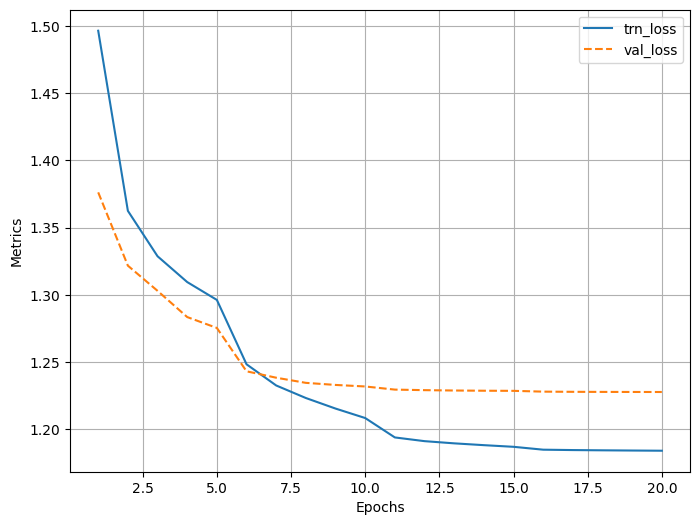

100%|██████████| 121/121 [00:06<00:00, 19.57it/s]


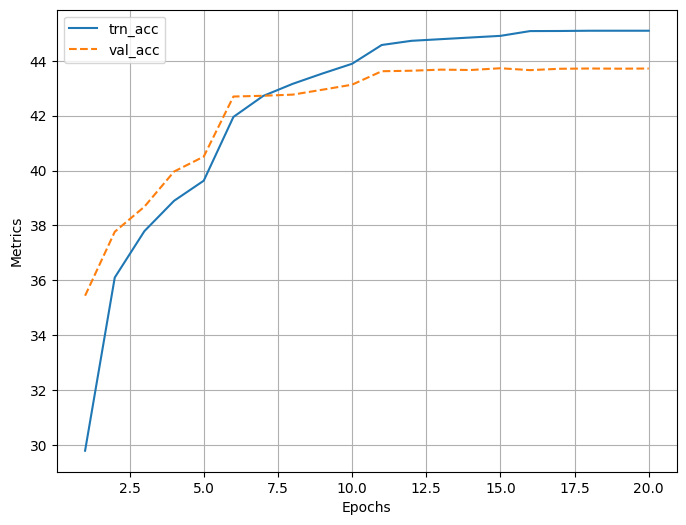

In [7]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

# Square Classifier


In [8]:
class SquareClassifier(nn.Module):
    def __init__(self):
        super(SquareClassifier, self).__init__()

        self.seq_forward = nn.Sequential(
            nn.Linear(100, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Linear(400, 300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 64),
            nn.BatchNorm1d(64)
        )
        
    def forward(self, x):
        output = self.seq_forward(x)
        return output

class SquareDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data[:,0:773]).type(torch.FloatTensor)
        self.y = torch.from_numpy(data[:,774]).type(torch.LongTensor)
        self.n_samples = data.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.n_samples

## Pawn

In [9]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 1]
dataValPawn = dataVal[dataVal[:, 773] == 1]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 212804

Val: 27011

In [10]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierPawn.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 35.749  trn_loss: 2.170  trn_acc: 32.722  val_loss: 2.033  (72.59s - 653.31s remaining)
EPOCH: 4.000  val_acc: 41.962  trn_loss: 1.817  trn_acc: 41.306  val_loss: 1.797  (145.06s - 580.24s remaining)
EPOCH: 6.000  val_acc: 46.946  trn_loss: 1.513  trn_acc: 49.574  val_loss: 1.610  (218.51s - 509.85s remaining)
EPOCH: 8.000  val_acc: 47.512  trn_loss: 1.423  trn_acc: 52.353  val_loss: 1.595  (290.51s - 435.76s remaining)
EPOCH: 10.000  val_acc: 47.526  trn_loss: 1.370  trn_acc: 53.965  val_loss: 1.595  (361.86s - 361.86s remaining)
EPOCH: 12.000  val_acc: 47.796  trn_loss: 1.322  trn_acc: 55.524  val_loss: 1.584  (433.80s - 289.20s remaining)
EPOCH: 14.000  val_acc: 47.766  trn_loss: 1.314  trn_acc: 55.770  val_loss: 1.583  (505.77s - 216.76s remaining)
EPOCH: 16.000  val_acc: 47.789  trn_loss: 1.304  trn_acc: 56.071  val_loss: 1.583  (577.22s - 144.31s remaining)
EPOCH: 18.000  val_acc: 47.778  trn_loss: 1.304  trn_acc: 56.106  val_loss: 1.583  (648.68s - 72.08s 

100%|██████████| 121/121 [00:01<00:00, 80.81it/s]


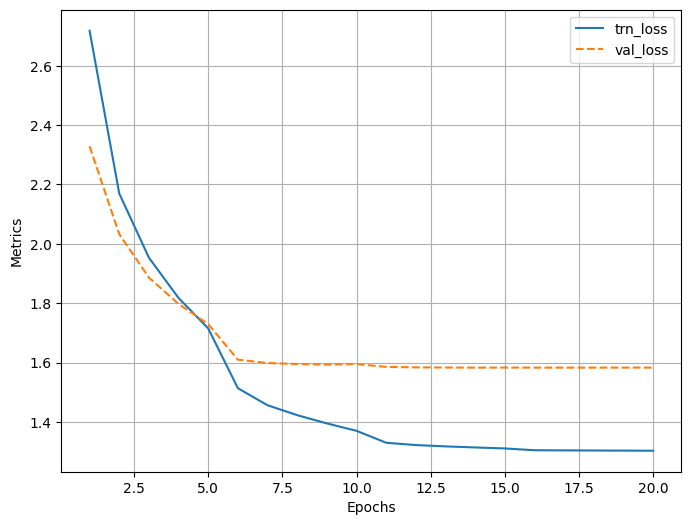

100%|██████████| 121/121 [00:01<00:00, 79.02it/s] 


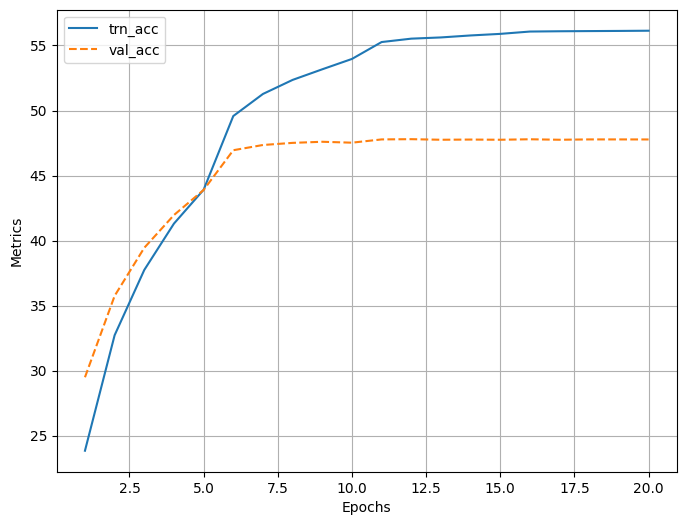

In [12]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## Knight

In [13]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 2]
dataValPawn = dataVal[dataVal[:, 773] == 2]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 148313

Val: 18406

In [14]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [15]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierKnight.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 40.811  trn_loss: 2.064  trn_acc: 37.022  val_loss: 1.893  (51.04s - 459.32s remaining)
EPOCH: 4.000  val_acc: 45.650  trn_loss: 1.714  trn_acc: 43.732  val_loss: 1.654  (102.81s - 411.24s remaining)
EPOCH: 6.000  val_acc: 49.430  trn_loss: 1.434  trn_acc: 50.979  val_loss: 1.514  (154.49s - 360.47s remaining)
EPOCH: 8.000  val_acc: 49.463  trn_loss: 1.347  trn_acc: 53.835  val_loss: 1.507  (206.27s - 309.40s remaining)
EPOCH: 10.000  val_acc: 49.687  trn_loss: 1.296  trn_acc: 55.536  val_loss: 1.509  (258.13s - 258.13s remaining)
EPOCH: 12.000  val_acc: 49.763  trn_loss: 1.251  trn_acc: 57.103  val_loss: 1.504  (309.39s - 206.26s remaining)
EPOCH: 14.000  val_acc: 49.855  trn_loss: 1.243  trn_acc: 57.367  val_loss: 1.504  (359.51s - 154.08s remaining)
EPOCH: 16.000  val_acc: 49.866  trn_loss: 1.234  trn_acc: 57.643  val_loss: 1.505  (409.68s - 102.42s remaining)
EPOCH: 18.000  val_acc: 49.953  trn_loss: 1.233  trn_acc: 57.689  val_loss: 1.505  (459.86s - 51.10s 

100%|██████████| 121/121 [00:01<00:00, 111.39it/s]


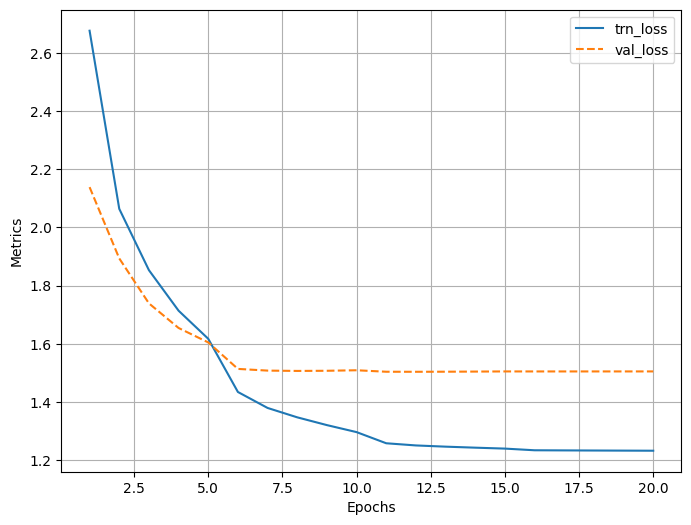

100%|██████████| 121/121 [00:01<00:00, 109.38it/s]


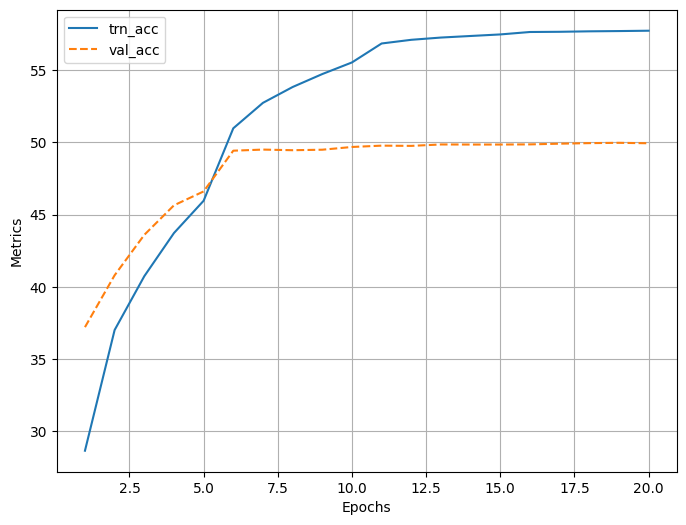

In [16]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## Bishop

In [17]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 3]
dataValPawn = dataVal[dataVal[:, 773] == 3]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 140312

Val: 17337

In [18]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierBishop.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 29.247  trn_loss: 2.575  trn_acc: 26.973  val_loss: 2.418  (46.97s - 422.74s remaining)
EPOCH: 4.000  val_acc: 33.914  trn_loss: 2.187  trn_acc: 33.363  val_loss: 2.169  (93.69s - 374.76s remaining)
EPOCH: 6.000  val_acc: 37.599  trn_loss: 1.857  trn_acc: 41.194  val_loss: 2.000  (140.39s - 327.58s remaining)
EPOCH: 8.000  val_acc: 38.638  trn_loss: 1.754  trn_acc: 43.971  val_loss: 1.987  (187.22s - 280.84s remaining)
EPOCH: 10.000  val_acc: 38.847  trn_loss: 1.693  trn_acc: 45.753  val_loss: 1.984  (233.96s - 233.96s remaining)
EPOCH: 12.000  val_acc: 38.760  trn_loss: 1.639  trn_acc: 47.559  val_loss: 1.977  (280.68s - 187.12s remaining)
EPOCH: 14.000  val_acc: 38.910  trn_loss: 1.631  trn_acc: 47.807  val_loss: 1.977  (327.38s - 140.31s remaining)
EPOCH: 16.000  val_acc: 38.835  trn_loss: 1.620  trn_acc: 48.055  val_loss: 1.977  (374.17s - 93.54s remaining)
EPOCH: 18.000  val_acc: 38.656  trn_loss: 1.619  trn_acc: 48.066  val_loss: 1.977  (420.95s - 46.77s re

100%|██████████| 121/121 [00:01<00:00, 110.38it/s]


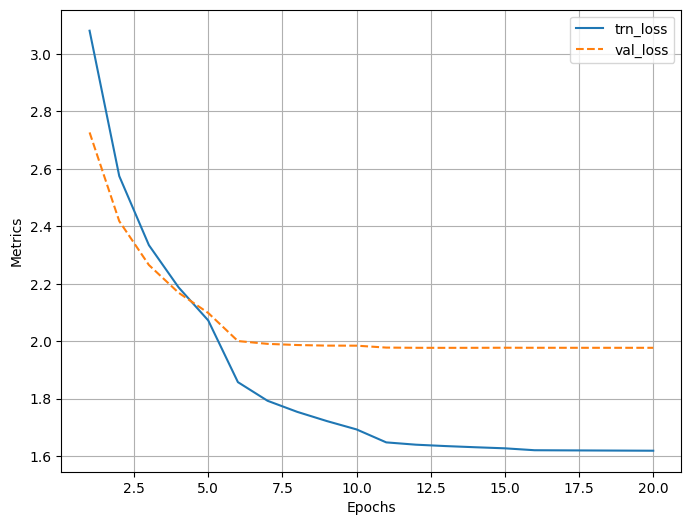

100%|██████████| 121/121 [00:01<00:00, 113.91it/s]


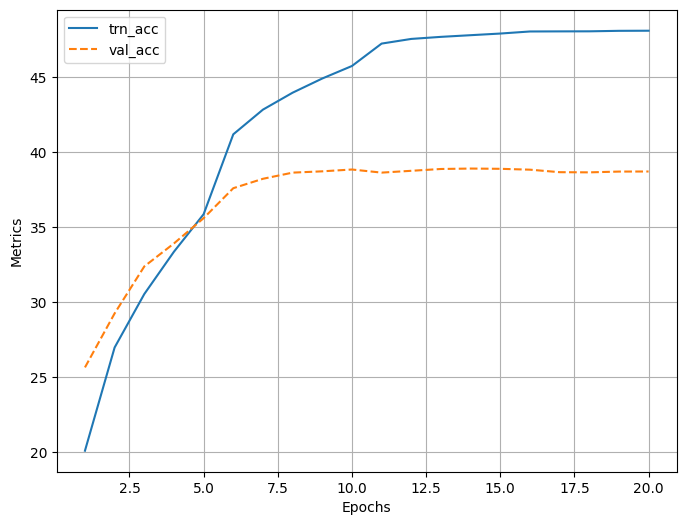

In [20]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## Rook

In [21]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 4]
dataValPawn = dataVal[dataVal[:, 773] == 4]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 156363

Val: 19483

In [22]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [23]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierRook.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 22.088  trn_loss: 2.930  trn_acc: 20.197  val_loss: 2.809  (52.08s - 468.75s remaining)
EPOCH: 4.000  val_acc: 26.335  trn_loss: 2.595  trn_acc: 25.459  val_loss: 2.576  (103.74s - 414.97s remaining)
EPOCH: 6.000  val_acc: 29.329  trn_loss: 2.285  trn_acc: 31.544  val_loss: 2.422  (155.51s - 362.85s remaining)
EPOCH: 8.000  val_acc: 29.949  trn_loss: 2.193  trn_acc: 33.740  val_loss: 2.408  (207.30s - 310.96s remaining)
EPOCH: 10.000  val_acc: 30.207  trn_loss: 2.136  trn_acc: 35.159  val_loss: 2.404  (257.67s - 257.67s remaining)
EPOCH: 12.000  val_acc: 30.265  trn_loss: 2.086  trn_acc: 36.467  val_loss: 2.397  (307.60s - 205.07s remaining)
EPOCH: 14.000  val_acc: 30.152  trn_loss: 2.078  trn_acc: 36.681  val_loss: 2.397  (357.39s - 153.17s remaining)
EPOCH: 16.000  val_acc: 30.127  trn_loss: 2.068  trn_acc: 36.902  val_loss: 2.397  (407.21s - 101.80s remaining)
EPOCH: 18.000  val_acc: 30.173  trn_loss: 2.068  trn_acc: 36.968  val_loss: 2.397  (457.01s - 50.78s 

100%|██████████| 121/121 [00:01<00:00, 104.47it/s]


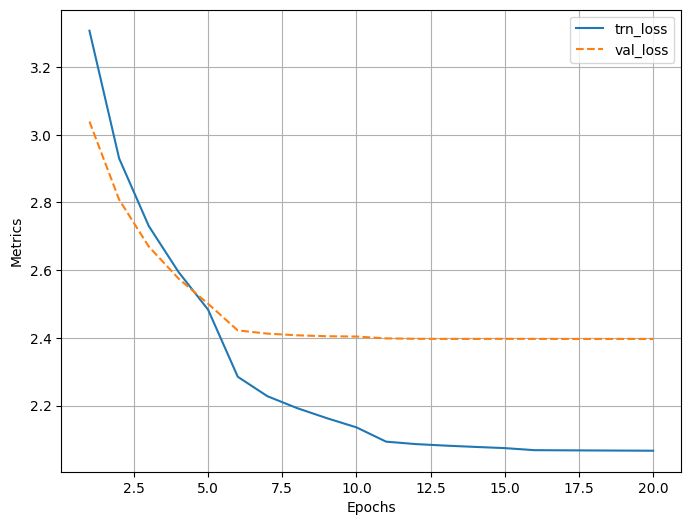

100%|██████████| 121/121 [00:01<00:00, 105.19it/s]


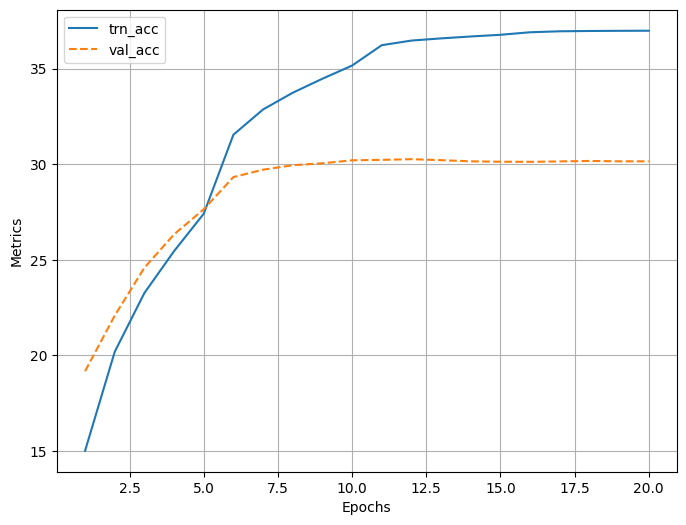

In [24]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## Queen

In [25]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 5]
dataValPawn = dataVal[dataVal[:, 773] == 5]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 144267

Val: 18005

In [26]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [27]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierQueen.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 16.456  trn_loss: 3.195  trn_acc: 14.885  val_loss: 3.109  (46.23s - 416.09s remaining)
EPOCH: 4.000  val_acc: 20.142  trn_loss: 2.882  trn_acc: 20.269  val_loss: 2.895  (92.49s - 369.98s remaining)
EPOCH: 6.000  val_acc: 23.715  trn_loss: 2.549  trn_acc: 27.105  val_loss: 2.713  (138.58s - 323.34s remaining)
EPOCH: 8.000  val_acc: 24.380  trn_loss: 2.442  trn_acc: 29.858  val_loss: 2.698  (184.70s - 277.04s remaining)
EPOCH: 10.000  val_acc: 24.530  trn_loss: 2.378  trn_acc: 31.408  val_loss: 2.695  (230.77s - 230.77s remaining)
EPOCH: 12.000  val_acc: 24.713  trn_loss: 2.323  trn_acc: 32.800  val_loss: 2.684  (276.80s - 184.53s remaining)
EPOCH: 14.000  val_acc: 24.669  trn_loss: 2.314  trn_acc: 33.077  val_loss: 2.683  (322.91s - 138.39s remaining)
EPOCH: 16.000  val_acc: 24.674  trn_loss: 2.303  trn_acc: 33.328  val_loss: 2.684  (368.96s - 92.24s remaining)
EPOCH: 18.000  val_acc: 24.674  trn_loss: 2.302  trn_acc: 33.373  val_loss: 2.683  (415.13s - 46.13s re

100%|██████████| 121/121 [00:01<00:00, 115.32it/s]


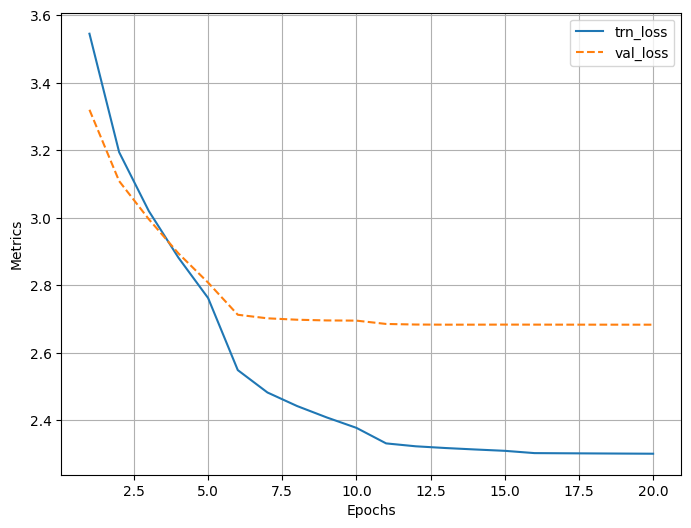

100%|██████████| 121/121 [00:01<00:00, 115.99it/s]


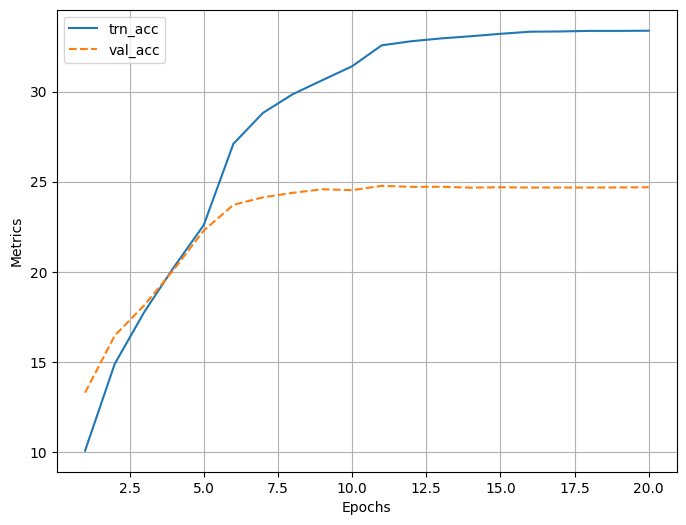

In [28]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## King

In [29]:
dataTrainPawn = dataTrain[dataTrain[:, 773] == 6]
dataValPawn = dataVal[dataVal[:, 773] == 6]

datasetTrain = SquareDataset(dataTrainPawn)
dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=64)

datasetVal = SquareDataset(dataValPawn)
dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=64)

print(f"Train: {len(dataLoaderTrain.dataset)}")
print(f"Val: {len(dataLoaderVal.dataset)}")

Train: 97425

Val: 12194

In [30]:
model_SC = SquareClassifier()
model_SC.to(device)
model_SC.train()

model_AE = Autoencoder()
checkpointDBN = torch.load("Mestrado/Models/autoencoder.pth")
model_AE.load_state_dict(checkpointDBN['model_state_dict'])
model_AE.to(device)
model_AE.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(model_SC.parameters()) + list(model_AE.parameters()), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [31]:
num_epochs = 20
log = Report(num_epochs)

PATH = 'Mestrado/Models/squareClassifierKing.pth'

for epoch in range(num_epochs):

    model_SC.train()
    model_AE.train()
    
    N = len(dataLoaderTrain)
    for bx, data in enumerate(dataLoaderTrain):

        total = 0
        right = 0
        
        pos, square = data

        pos = pos.to(device)
        square = square.to(device)

        _, code = model_AE(pos)

        pred = model_SC(code)

        loss = criterion(pred, square)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = pred.cpu().detach().numpy().astype(int)
        corr = square.cpu().detach().numpy().astype(int)

        for i in range(len(pred)):
            total += 1
            max_ind = np.argmax(pred[i])
            if max_ind == corr[i]:
                right += 1
        
        acc = right/total * 100

        

        log.record((epoch+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    model_SC.eval()
    model_AE.eval()

    N = len(dataLoaderVal)
    with torch.no_grad():
        for bx, data in enumerate(dataLoaderVal):
            total = 0
            right = 0

            pos, square = data

            pos = pos.to(device)
            square = square.to(device)

            _, code = model_AE(pos)

            pred = model_SC(code)

            loss = criterion(pred, square)

            pred = pred.cpu().detach().numpy().astype(int)
            corr = square.cpu().detach().numpy().astype(int)

            for i in range(len(pred)):
                total += 1
                max_ind = np.argmax(pred[i])
                if max_ind == corr[i]:
                    right += 1

            acc = right/total * 100

            log.record((epoch+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1)%2==0: log.report_avgs(epoch+1)
    lr_scheduler.step()

torch.save({
    'epoch': epoch,
    'model_state_dict_PC': model_SC.state_dict(),
    'model_state_dict_AE': model_AE.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
    }, PATH)



EPOCH: 2.000  val_acc: 39.813  trn_loss: 1.824  trn_acc: 38.757  val_loss: 1.682  (31.38s - 282.39s remaining)
EPOCH: 4.000  val_acc: 42.905  trn_loss: 1.545  trn_acc: 43.338  val_loss: 1.517  (62.69s - 250.76s remaining)
EPOCH: 6.000  val_acc: 47.009  trn_loss: 1.339  trn_acc: 49.319  val_loss: 1.388  (96.52s - 225.22s remaining)
EPOCH: 8.000  val_acc: 47.474  trn_loss: 1.273  trn_acc: 51.709  val_loss: 1.380  (131.29s - 196.93s remaining)
EPOCH: 10.000  val_acc: 47.662  trn_loss: 1.233  trn_acc: 53.364  val_loss: 1.379  (164.98s - 164.98s remaining)
EPOCH: 12.000  val_acc: 48.111  trn_loss: 1.197  trn_acc: 54.902  val_loss: 1.365  (197.99s - 131.99s remaining)
EPOCH: 14.000  val_acc: 48.200  trn_loss: 1.191  trn_acc: 55.101  val_loss: 1.364  (231.00s - 99.00s remaining)
EPOCH: 16.000  val_acc: 48.321  trn_loss: 1.185  trn_acc: 55.412  val_loss: 1.365  (264.05s - 66.01s remaining)
EPOCH: 18.000  val_acc: 48.288  trn_loss: 1.184  trn_acc: 55.426  val_loss: 1.364  (296.99s - 33.00s rema

100%|██████████| 121/121 [00:00<00:00, 164.81it/s]


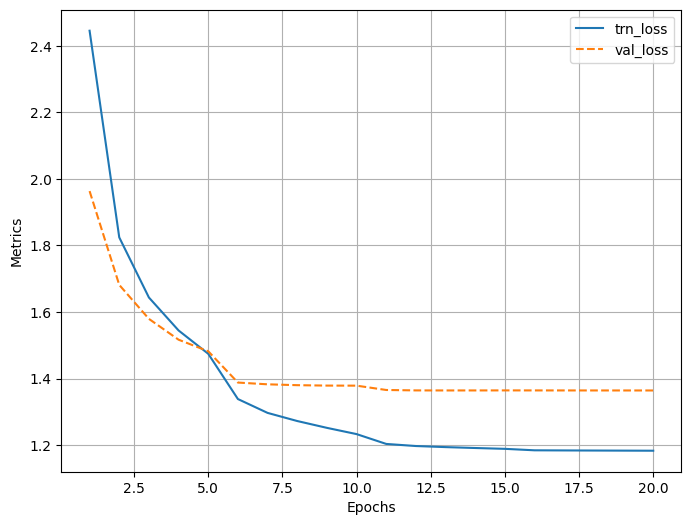

100%|██████████| 121/121 [00:00<00:00, 173.31it/s]


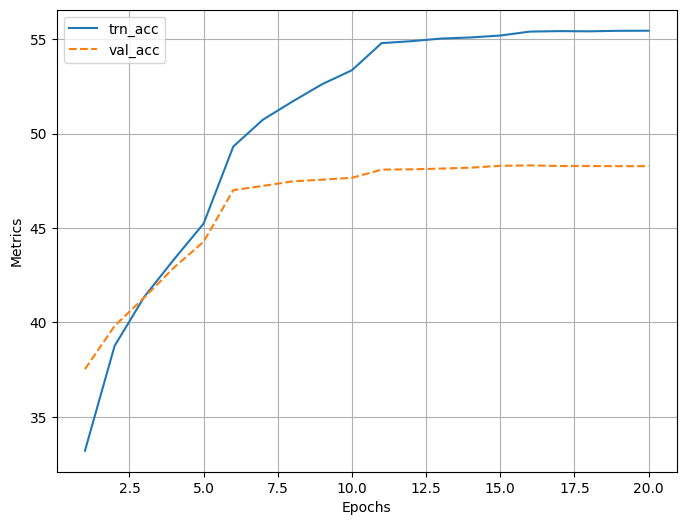

: 

In [32]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

# Testando Predição

In [9]:
# Load Piece Classifier
load_PC = torch.load("Mestrado\Models\pieceClassifier.pth")

model_PC = PieceClassifier()
model_PC.load_state_dict(load_PC['model_state_dict_PC'])
model_PC.to(device)
model_PC.eval()

model_AE_PC = Autoencoder()
model_AE_PC.load_state_dict(load_PC['model_state_dict_AE'])
model_AE_PC.to(device)
model_AE_PC.eval()

# Load Square Classifier Pawn
load_SC = torch.load("Mestrado\Models\squareClassifierPawn.pth")

model_SC_P = SquareClassifier()
model_SC_P.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_P.to(device)
model_SC_P.eval()

model_AE_SC_P = Autoencoder()
model_AE_SC_P.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_P.to(device)
model_AE_SC_P.eval()

# Load Square Classifier Knight
load_SC = torch.load("Mestrado\Models\squareClassifierKnight.pth")

model_SC_N = SquareClassifier()
model_SC_N.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_N.to(device)
model_SC_N.eval()

model_AE_SC_N = Autoencoder()
model_AE_SC_N.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_N.to(device)
model_AE_SC_N.eval()

# Load Square Classifier Bishop
load_SC = torch.load("Mestrado\Models\squareClassifierBishop.pth")

model_SC_B = SquareClassifier()
model_SC_B.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_B.to(device)
model_SC_B.eval()

model_AE_SC_B = Autoencoder()
model_AE_SC_B.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_B.to(device)
model_AE_SC_B.eval()

# Load Square Classifier Rook
load_SC = torch.load("Mestrado\Models\squareClassifierRook.pth")

model_SC_R = SquareClassifier()
model_SC_R.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_R.to(device)
model_SC_R.eval()

model_AE_SC_R = Autoencoder()
model_AE_SC_R.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_R.to(device)
model_AE_SC_R.eval()

# Load Square Classifier Queen
load_SC = torch.load("Mestrado\Models\squareClassifierQueen.pth")

model_SC_Q = SquareClassifier()
model_SC_Q.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_Q.to(device)
model_SC_Q.eval()

model_AE_SC_Q = Autoencoder()
model_AE_SC_Q.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_Q.to(device)
model_AE_SC_Q.eval()

# Load Square Classifier King
load_SC = torch.load("Mestrado\Models\squareClassifierKing.pth")

model_SC_K = SquareClassifier()
model_SC_K.load_state_dict(load_SC['model_state_dict_PC'])
model_SC_K.to(device)
model_SC_K.eval()

model_AE_SC_K = Autoencoder()
model_AE_SC_K.load_state_dict(load_SC['model_state_dict_AE'])
model_AE_SC_K.to(device)
model_AE_SC_K.eval()

print("Loaded Models")

Loaded Models

In [10]:
def get_squares_for_piece_type(board, piece_type, color):
    squares = [square for square in ch.SQUARES if board.piece_type_at(square) == piece_type and board.color_at(square) == color]
    return squares

def get_legal_moves_for_piece(board, squares_with_piece):
    legal_moves = []

    for square in squares_with_piece:
        for move in board.legal_moves:
            if move.from_square == square:
                legal_moves.append(move.to_square)

    return legal_moves

In [11]:

def process_csv_file(csv_file):
    df = pd.read_csv(csv_file)

    total_correct_both = 0
    total_samples = 0

    for index, row in df.iterrows():
        position = row['Position']
        fen = row['FEN']
        next_move = row['NextMove']

        board = ch.Board(fen)

        color_to_move = board.turn

        
        if color_to_move == ch.WHITE:

            inputs = position.split(' ')

            init_square= next_move[0:2]
            end_square= next_move[2:4]

            init_square = ch.parse_square(init_square)
            end_square = ch.parse_square(end_square)

            correct_piece = board.piece_type_at(init_square)

            inputs = np.array(inputs).astype(int)
            inputs = torch.tensor(inputs, dtype=torch.float32)
            inputs = inputs.unsqueeze(0)
            inputs = inputs.to(device)

            _, code = model_AE_PC(inputs)

            outputs_piece = model_PC(code)

            piece_prob = dict()

            for index, piece in enumerate(outputs_piece[0]):
                piece_prob[index+1] = piece.item()
            
            sorted_piece_prob = dict(sorted(piece_prob.items(), key=lambda item: item[1], reverse=True))


            for pred_piece in sorted_piece_prob:
                squares_with_piece = get_squares_for_piece_type(board, pred_piece, ch.WHITE)
        
                if len(squares_with_piece) > 0:
                    legal_moves_for_piece = get_legal_moves_for_piece(board,squares_with_piece)

                    if len(legal_moves_for_piece) > 0:
                        predicted_piece = pred_piece
                        break

            predicted_square = None
            if predicted_piece == 1:
                _,code = model_AE_SC_P(inputs)
                outputs_square = model_SC_P(code)

            elif predicted_piece == 2:
                _,code = model_AE_SC_N(inputs)
                outputs_square = model_SC_N(code)

            elif predicted_piece == 3:
                _,code = model_AE_SC_B(inputs)
                outputs_square = model_SC_B(code)

            elif predicted_piece == 4:
                _,code = model_AE_SC_R(inputs)
                outputs_square = model_SC_R(code)

            elif predicted_piece == 5:
                _,code = model_AE_SC_Q(inputs)
                outputs_square = model_SC_Q(code)

            elif predicted_piece == 6:
                _,code = model_AE_SC_K(inputs)
                outputs_square = model_SC_K(code)

            square_prob = dict()

            for index, square in enumerate(outputs_square[0]):
                if index in legal_moves_for_piece:
                    square_prob[index] = square.item()
            
            sorted_square_prob = dict(sorted(square_prob.items(), key=lambda item: item[1], reverse=True))

            
            first_element = next(iter(sorted_square_prob.items()))
            predicted_square = first_element[0]

            if (predicted_piece == correct_piece) and (predicted_square == end_square):
                total_correct_both += 1
            
            total_samples += 1
    
    print(f"{total_correct_both}, {total_samples}, {(total_correct_both/total_samples*100):.2f}%")

 
    return



In [12]:
csv_file_path = "Mestrado/Data/test.csv"
process_csv_file(csv_file_path)

28989, 112375, 25.80%

In [3]:
import pandas as pd
import chess as ch
import chess.svg
import random

def process_csv_file(csv_file):
    df = pd.read_csv(csv_file)

    total_correct_both = 0
    total_samples = 0

    for index, row in df.iterrows():
        position = row['Position']
        fen = row['FEN']
        next_move = row['NextMove']

        board = ch.Board(fen)

        color_to_move = board.turn
        
        if color_to_move == ch.WHITE:
            legal_moves = [move.uci() for move in board.legal_moves]
            if legal_moves:
                random_move = legal_moves[random.randint(0, len(legal_moves) - 1)]
                if random_move == next_move:
                    total_correct_both += 1
            
            total_samples += 1

    print(f"{total_correct_both}, {total_samples}, {(total_correct_both/total_samples*100):.2f}%")
    return



process_csv_file('Mestrado/Data/test.csv')


5928, 112375, 5.28
